In [19]:
from statistics import multimode
from Models_DEAP import *
from Utils import *
from Utils_Bashivan import *
import time
import warnings

warnings.simplefilter("ignore")

t = time.time()

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
device

device(type='cpu')

In [4]:
# X_image = np.load('Example_Input/img.npy') # place here the images representation of EEG
# X_array = np.load('Example_Input/array.npy') # place here the array representation of EEG features
# Label = np.load('Example_Input/label.npy') # place here the label for each EEG
# Participant = np.load('Example_Input/participant.npy') # place here the array with each participants

In [5]:
deap_path = '../../datasets/DEAP/'

In [14]:
X_image = np.load('../../datasets/DEAP/image_generation/images.npy') # place here the images representation of EEG
X_array = np.load('../../datasets/DEAP/merged/deap_data.npy') # place here the array representation of EEG features
Label_full = np.load('../../datasets/DEAP/merged/deap_full_labels.npy') # place here the label for each EEG
Participant = np.load('../../datasets/DEAP/image_generation/participants.npy') # place here the array with each participants

In [15]:
print(X_image.shape)
print(X_array.shape)
print(Label.shape)
print(Participant.shape)

(1280, 5, 32, 32)
(1280, 40, 8064)
(1280, 3)
(1280,)


In [16]:
Label = Label_full[:, 2]

In [17]:
set(Label)

{0, 1, 2, 3}

In [18]:
print(set(Participant))

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0}


In [46]:
X_array[0, :5] #maybe it's Raw EEG with 62 channels (SEED dataset has as many) and 3 time samples?

array([[1.17473619e-08, 3.10600131e-02, 1.79858819e+01],
       [9.36758205e-09, 1.67285569e-02, 3.50138035e+01],
       [2.88355346e-09, 4.68864365e-02, 1.25750405e+01],
       [6.11320269e-10, 1.94063392e-01, 2.92320866e+00],
       [1.48742042e-08, 3.34711148e-02, 1.74300392e+01]])

In [6]:
X_image[0, 0, 5:-4, 6:-6]

array([[ 4.42245408e-02,  2.58359283e-02, -1.10436889e-02,
        -4.00641110e-02, -4.92576852e-02, -2.70491824e-02,
         7.62167854e-02,  2.32853384e-01,  3.94829697e-01,
         5.46737805e-01,  6.12570331e-01,  5.44668456e-01,
         4.21792621e-01,  2.74374431e-01,  1.03387553e-01,
        -3.52871148e-02, -1.09122962e-01, -1.55356166e-01,
        -1.78913836e-01, -1.84880107e-01],
       [ 3.74259407e-02,  2.03805748e-02, -4.56902962e-02,
        -1.08412304e-01, -1.47398563e-01, -1.49869624e-01,
        -1.00624177e-01,  4.16621417e-03,  1.40547191e-01,
         2.83406104e-01,  3.47541229e-01,  2.85996417e-01,
         1.76649245e-01,  6.06711997e-02, -5.01678089e-02,
        -1.37323151e-01, -1.86606471e-01, -2.06220022e-01,
        -2.01989034e-01, -1.86203413e-01],
       [ 5.06530394e-02,  4.73351593e-02, -1.12567863e-02,
        -9.59950735e-02, -1.65575818e-01, -2.12661418e-01,
        -2.02340293e-01, -1.50528797e-01, -5.97722973e-02,
         5.66306644e-02,  1.1

In [7]:
image = np.moveaxis(X_image[0], 0 ,-1)

In [8]:
image = (image - np.min(image)) / (np.max(image) - np.min(image))

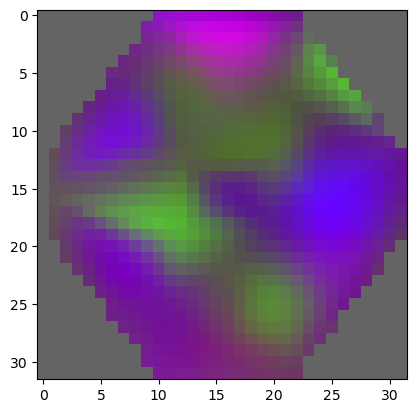

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()

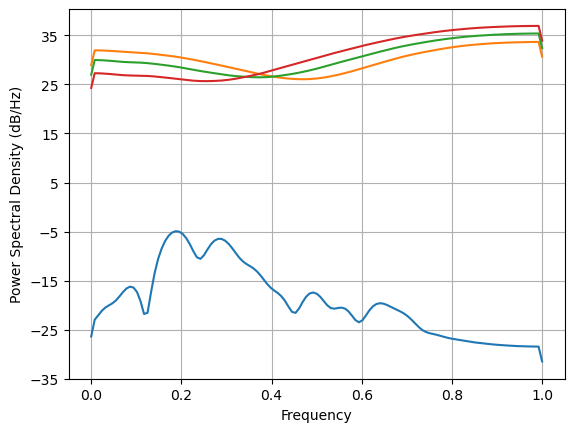

In [20]:
freqs = X_array[0, :, :]

plt.psd(freqs) #sum of the other 3?
plt.psd(X_array[0, :, 0])
plt.psd(X_array[0, :, 1])
plt.psd(X_array[0, :, 2])
plt.show()

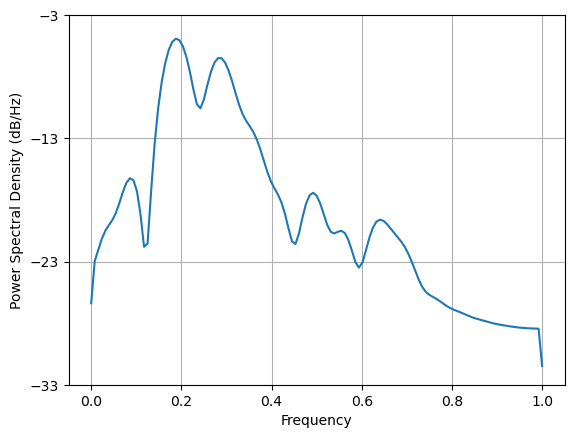

In [21]:
plt.psd(X_array[0, :, :])
plt.show()

In [22]:
n_epoch = 150

In [23]:
Dataset = CombDataset(label=Label, image=X_image, array=X_array) #creation of
#dataset classs in Pytorch

In [24]:
# electrodes locations in 3D -> 2D projection
locs_3d = np.load('Electroloc/Neuro_loc_DEAP.npy')[:31]
locs_2d = []
for e in locs_3d:
    locs_2d.append(azim_proj(e))

mutl_img = torch.ones((X_image.shape[1], 32, 32)) #initiate the gain matrice

In [25]:
locs_3d.shape

(31, 3)

In [26]:
np.asarray(locs_2d).shape

(31, 2)

Uses LOSO (Leave One Subject Out) Cross Validation

In [14]:
for p in range(len(np.unique(Participant))):
    print("Training participant ", p)

    #Splitting in Train and Testing Set
    idx = np.argwhere(Participant == p)[:, 0]
    np.random.shuffle(idx)
    Test = Subset(Dataset, idx)
    idx = np.argwhere(Participant != p)[:, 0]
    np.random.shuffle(idx)
    Train = Subset(Dataset, idx)

    #Train Test Loader Pytorch
    Trainloader = DataLoader(Train, batch_size=128, shuffle=False)
    Testloader = DataLoader(Test, batch_size=128, shuffle=False)

    #Set training parameters
    lr = 1e-3
    wd = 1e-4
    mom= 0.9

    net = MultiModel(X_image).to(device)
    #optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mom,  weight_decay=wd)
    optimizer = optim.Adam(net.parameters(), lr=lr,  weight_decay=wd)

    Res = []

    validation_loss = 0.0
    validation_acc = 0.0

    for epoch in range(n_epoch):
        running_loss = 0.0
        evaluation = []

        #Training
        net.train()
        for i, data, data_test in iter_over(Trainloader, Testloader):
            source_img, source_arr, label = data #signals from training
            target_img, target_arr, _ = data_test #signals with unknwon label

            # Image Representaion + multiplication with gain matrix from saliency
            img = torch.cat([source_img, target_img])
            img = img * mutl_img
            img = img.to(device)

            # Array Representation
            arr = torch.cat([source_arr, target_arr])
            arr = arr.to(device)

            # True Domain
            domain_y = torch.cat([torch.ones(source_img.shape[0]),
                                  torch.zeros(target_img.shape[0])])
            domain_y = domain_y.to(device)

            # True Label
            label = label.to(device)

            # Estimation of both feature vectors + concat
            feat_img = net.FeatCNN(img.to(torch.float32).to(device))
            feat_arr = net.FeatRNN(arr.to(torch.float32).to(device))
            feat = torch.cat((feat_img, feat_arr), axis=1)

            # Domain and Label prediction
            domain_pred = net.Discriminator(feat).squeeze()
            label_pred = net.ClassifierFC(feat[:source_img.shape[0]])

            # Loss Computing
            domain_loss = F.binary_cross_entropy_with_logits(domain_pred, domain_y)
            label_loss = F.cross_entropy(label_pred, label.long())

            # Loss Backward
            optimizer.zero_grad()
            loss = domain_loss + label_loss
            loss.backward()
            optimizer.step()
            running_loss += label_loss.item()

            # Prediction and Accuracy
            _, predicted = torch.max(label_pred, 1)
            num_of_true = torch.sum(predicted == label)
            mean = num_of_true/label.shape[0]
            evaluation.append(mean)

        running_loss = running_loss / (i + 1)
        running_acc = sum(evaluation) / len(evaluation)

        evaluation = []

        #Evaluation
        net.eval()
        for j, data in enumerate(Testloader, 0):
            img, arr, label = data

            # Prediction
            pred = net(img.to(torch.float32).to(device), arr.to(torch.float32).to(device))
            loss = F.cross_entropy(pred, label.to(device).long())

            # Loss
            validation_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(pred.cpu().data, 1)
            evaluation.append((predicted == label).tolist())

            # Updating the saliency of RNN
            X = arr.to(torch.float32).to(device)
            X.requires_grad_()
            net.train()
            scores = net.FeatRNN(X)
            score_max_index = scores.mean(axis=0).argmax()
            score_max = scores[0,score_max_index]
            score_max.backward()
            net.eval()
            saliency, _ = torch.max(X.grad.data.abs(),dim=2)
            saliency = saliency.mean(axis=0).cpu().detach().numpy()
            saliency[np.isnan(saliency)] = 0
            saliency = gen_images(np.asarray(locs_2d), saliency.reshape((1,62)), 32)[0,0]
            saliency = np.stack(X_image.shape[1]*[saliency])
            saliency[np.isnan(saliency)] = 0
            saliency = saliency**2
            saliency = (saliency/saliency.max()+0.05)*2
            mutl_img = torch.from_numpy(saliency)

        validation_loss = validation_loss /(j+1)
        evaluation = [item for sublist in evaluation for item in sublist]
        validation_acc = sum(evaluation) / len(evaluation)

        print('[%d, %3d] \t loss: %.3f\tAccuracy : %.3f\t\tval-loss: %.3f\tval-Accuracy : %.3f' %
                      (epoch + 1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))

        Res.append((epoch + 1, n_epoch, running_loss, running_acc, validation_loss, validation_acc))
    path =  'res/sub'+str(p)+'/'
    np.save(path+'rec_'+str(len(glob.glob(path+'*.npy')))+'_lr_'+str(lr)+'_wd_'+str(wd)+'_mom_'+str(mom), Res)
    print('End after_'+str(np.round(time.time() - t, 3))+'\n')
    t = time.time()

Training participant  0
[1, 150] 	 loss: 2.076	Accuracy : 0.106		val-loss: 2.119	val-Accuracy : 0.062
[2, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[3, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[4, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[5, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[6, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[7, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[8, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[9, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[10, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[11, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[12, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[13, 150] 	 loss: nan	Accuracy : 0.101		val-loss: nan	val-Accuracy : 0.125
[14, 1

KeyboardInterrupt: 